In [1]:
# Import Packages
import pandas as pd
import numpy  as np
from quantbt import Portfolio, yfDataHandler

print('Modules Loaded Successfully!')

Modules Loaded Successfully!


In [2]:
# Initialize some data sets from Yahoo finance
syms = ["AAPL","META","NFLX","AMZN","GOOG"]

# Yahoo Finance data source
dataSource = yfDataHandler(syms)

# Get the raw data
dates,prices_df = dataSource.getDataFromSource('2014-01-01','2023-10-01')

# Get prices as dictionary for ingesting
prices = prices_df.to_dict(orient = 'index')


[*********************100%%**********************]  5 of 5 completed


In [27]:
# Define signal computation here
def computeMomentumSignal(prices):
    momentumWindow = 252
    return np.sign( prices.tail(momentumWindow).iloc[-1] / prices.tail(momentumWindow).iloc[0] - 1)
    
def computeCrossoverSignal(prices):
    fastWindow = 50
    slowWindow = 200
    signal = (prices.tail(fastWindow).mean() > prices.tail(slowWindow).mean()).astype(int) # Long only - replace 0 with -1 to go short
    return signal

def computeRiskSignal(prices):
    riskTarget = 0.35
    riskWindow = 260
    return riskTarget / ( prices_df.tail(riskWindow).pct_change(1).std(ddof=1) * np.sqrt(252) )

In [31]:
# Initialize Portfolio object
samplePortfolio = Portfolio({},1_000,name='Risk Adj Momentum Portfolio',datadump=False)
benchmarkPortfolio = Portfolio({},1_000,name='Buy and Hold EW Portfolio',datadump=False)

# Set some costs for realistic assumption
samplePortfolio.setFixedTransactionCosts({asset:0.0001 for asset in syms})
benchmarkPortfolio.setFixedTransactionCosts({asset:0.0001 for asset in syms})

# Define Rebalance Trigger - every month
rebalanceTrigger = pd.tseries.offsets.BMonthEnd()

print('Portfolios Initalized!')

print(f'Beginning backtest from {dates[0]} to {dates[-1]}')

for i,date in enumerate(dates):
    
    # Design strategy rules here
    if (date == rebalanceTrigger.rollforward(date)) and (i > 260):
        
        # Compute signal
        momSignal  = computeCrossoverSignal(prices_df.iloc[:i]).to_dict()
        riskSignal = computeRiskSignal(prices_df.iloc[:i]).to_dict()

        # Equal weighted momentum risk-adjusted signal (no leverage assumed)
        targetWeights = { asset : (1/len(syms)) * momSignal.get(asset) * min(1,riskSignal.get(asset)) for asset in syms }
        
        samplePortfolio.rebalance(targetWeights,prices[date],date)

        # Benchmark equal weight buy and hold
        if benchmarkPortfolio.FirstRebalanceDate == 'N/A':
            benchmarkWeights = { asset : 1/len(syms) for asset in syms }
            benchmarkPortfolio.rebalance(benchmarkWeights,prices[date],date)

    # Mark to market pnl at every iteration 
    samplePortfolio.signOff(date,prices[date])
    benchmarkPortfolio.signOff(date,prices[date])

print('Backtest Complete!')

Portfolios Initalized!
Beginning backtest from 2014-01-02 00:00:00 to 2023-09-29 00:00:00
Backtest Complete!


<AxesSubplot:>

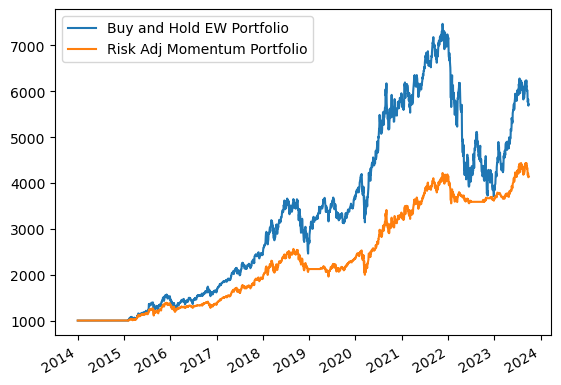

In [32]:
# Examine Portfolio Performance
comparePortfolios = pd.concat([benchmarkPortfolio.getHistoricalNAV(),samplePortfolio.getHistoricalNAV()],axis=1)
comparePortfolios.columns = [benchmarkPortfolio.getPortfolioName(),samplePortfolio.getPortfolioName()]
comparePortfolios.plot()

In [30]:
print( '*' * 35, samplePortfolio.getPortfolioName(), samplePortfolio.getPerformanceStatistics(historical=False).T, sep='\n')
print( '*' * 35, benchmarkPortfolio.getPortfolioName(), benchmarkPortfolio.getPerformanceStatistics(historical=False).T, sep='\n')

***********************************
Risk Adj Momentum Portfolio
                         2023-09-29
Annual Returns             0.157062
Annual Volatility          0.172419
Sharpe Ratio               0.910933
Cumulative Return          3.144038
Maximum Drawdown          -0.156997
Sortino Ratio              1.036421
Calmar Ratio              -1.000414
Total Transaction Costs    2.670673
***********************************
Buy and Hold EW Portfolio
                         2023-09-29
Annual Returns             0.195869
Annual Volatility          0.269482
Sharpe Ratio               0.726835
Cumulative Return          4.715345
Maximum Drawdown          -0.503408
Sortino Ratio              0.903168
Calmar Ratio              -0.389085
Total Transaction Costs    0.100000
